[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ThomasAlbin/Astroniz-YT-Tutorials/blob/main/[ML1]-Asteroid-Spectra/10_dl_hyperparameter_search.ipynb)

# Step 10: Deep Learning - Hyperparameter Optimization

Finally, we'll use Keras Tuner to optimize our classifier by a few percent more!

In [1]:
%load_ext tensorboard
!pip install keras-tuner

In [2]:
# Import standard libraries
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn import preprocessing
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow.keras as keras

In [3]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""
    
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

asteroids_X = np.expand_dims(asteroids_X, axis=2)

In [4]:
# We need to encode our string-based labels to either a sparse representation (class C becomes 0,
# S becomes 1, etc.) or to One-Hot-Encoding (e.g., C becomes [1, 0, 0, 0], S becomes [0, 1, 0, 0]
# and so on.

# Please note: a better way to create models that can be used in production, encoding shall be
# stored e.g., in a json file. Otherwise one needs to store the encoding class (otherwise the
# encoding - decoding information is gone!!!)
label_encoder = preprocessing.OneHotEncoder(sparse=True)
asteroids_oh_y = label_encoder.fit_transform(asteroids_y.reshape(-1,1)).toarray()

# OK how are things encoded?
oh_init = [1, 0, 0, 0]
for n in range(4):
    oh_class = oh_init[-n:] + oh_init[:-n]
    org_class = label_encoder.inverse_transform([oh_class])
    print(f"One-Hot-Vector {oh_class} corresponds to the Main Group: {org_class[0][0]}")
    
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_oh_y[train_index], asteroids_oh_y[test_index]

One-Hot-Vector [1, 0, 0, 0] corresponds to the Main Group: C
One-Hot-Vector [0, 1, 0, 0] corresponds to the Main Group: Other
One-Hot-Vector [0, 0, 1, 0] corresponds to the Main Group: S
One-Hot-Vector [0, 0, 0, 1] corresponds to the Main Group: X


## Imbalanced Datasets

... are a pain to work with. But it doesn't need to be, if you are aware of some pitfalls and useful metrics. Tensorflow provides a nice blog post [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

In [5]:
# We need to create weights for our samples. Similar like the class weights, but here, our classes
# are one-hot encoded. Sample weights are easier to handle!
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight("balanced", y=y_train)

In [6]:
import keras_tuner as kt

# Early Stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Get the number of inputs
n_inputs = asteroids_X.shape[1]

# We move our normalizer layers outside of the function
normalizer = keras.layers.Normalization(axis=1)
normalizer.adapt(X_train)

def create_model(hp):
    
    # Create now a simple Dense based network
    input_layer = keras.Input(shape=(n_inputs, 1))

    norm_layer = normalizer(input_layer)

    
    hidden_layer = keras.layers.Conv1D(filters=hp.Int("1st_filters",
                                                      min_value=8,
                                                      max_value=32,
                                                      step=8),
                                       activation="relu",
                                       kernel_size=hp.Int("1st_kernel_size",
                                                          min_value=3,
                                                          max_value=7,
                                                          step=1))(norm_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)
    
    hidden_layer = keras.layers.Conv1D(filters=hp.Int("2nd_filters",
                                                      min_value=16,
                                                      max_value=128,
                                                      step=16),
                                       activation="relu",
                                       kernel_size=hp.Int("2nd_kernel_size",
                                                          min_value=3,
                                                          max_value=7,
                                                          step=1))(norm_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)
    
    hidden_layer = keras.layers.Flatten()(hidden_layer)
    hidden_layer = keras.layers.Dense(hp.Int("units", min_value=8, max_value=64, step=8),
                                      activation="relu")(hidden_layer)

    if hp.Boolean("dropout"):
        hidden_layer = keras.layers.Dropout(hp.Float("dr_rate",
                                                     min_value=0.1,
                                                     max_value=0.5,
                                                     step=0.1))(hidden_layer)
    
    output_layer = keras.layers.Dense(4, activation="softmax")(hidden_layer)

    # Create now the model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    
    return model

# Let's create our tuner, optimizing a val_loss search. You can replace the Optimizer e.g.
# with a Bayesion Search or Hyperband optimization
tuner = kt.RandomSearch(create_model,
                        objective='val_loss',
                        max_trials=25)

# Number of epochs and batch size
end_epoch = 400
batch_size = 64

# Searching now for the best solution
tuner.search(X_train,
             y_train,
             batch_size=batch_size,
             verbose=0, 
             validation_split=0.25, epochs=end_epoch,
             sample_weight=sample_weight,
             callbacks=[es_callback, keras.callbacks.TensorBoard()])

# Get the best model
model = tuner.get_best_models()[0]

2022-04-02 15:38:38.547056: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Oracle triggered exit


In [7]:
# You can also print all tuner results
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
1st_filters: 24
1st_kernel_size: 6
2nd_filters: 48
2nd_kernel_size: 7
units: 32
dropout: True
dr_rate: 0.4
Score: 0.03862129524350166
Trial summary
Hyperparameters:
1st_filters: 24
1st_kernel_size: 4
2nd_filters: 80
2nd_kernel_size: 6
units: 56
dropout: True
dr_rate: 0.2
Score: 0.03890017047524452
Trial summary
Hyperparameters:
1st_filters: 24
1st_kernel_size: 4
2nd_filters: 80
2nd_kernel_size: 6
units: 24
dropout: True
dr_rate: 0.30000000000000004
Score: 0.041760142892599106
Trial summary
Hyperparameters:
1st_filters: 16
1st_kernel_size: 4
2nd_filters: 80
2nd_kernel_size: 4
units: 64
dropout: False
dr_rate: 0.5
Score: 0.04219847917556763
Trial summary
Hyperparameters:
1st_filters: 16
1st_kernel_size: 4
2nd_filters: 80
2nd_kernel_size: 5
units: 40
dropout: True
dr_rate: 0.1
Score: 0.04254813864827156
Trial summary
Hyperparameters:
1st_filters: 24
1st_kernel_size: 4
2nd_filters: 112
2nd_k

In [8]:
# Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 normalization (Normalizatio  (None, 49, 1)            99        
 n)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 43, 48)            384       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 21, 48)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1008)              0         
                                                                 
 dense (Dense)               (None, 32)                32288 

In [9]:
# The best trial id. We'll use it to check the corresponding history in the ...
tuner.oracle.get_best_trials()[0].trial_id

'05'

In [10]:
# ... tensorboard!
%tensorboard --logdir logs

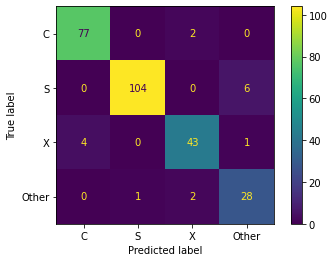

F1 Score: 0.941


In [11]:
# Compute class probabilities
y_test_prop_pred = model.predict(X_test)

# Compute the corresponding one-hot classes
y_test_oh_pred = np.zeros_like(y_test_prop_pred)
y_test_oh_pred[np.arange(len(y_test_prop_pred)), y_test_prop_pred.argmax(1)] = 1

# Re-transform the classes now!
asteroid_classes_test = label_encoder.inverse_transform(y_test).reshape(1, -1)[0]
asteroid_classes_test_pred = label_encoder.inverse_transform(y_test_oh_pred).reshape(1, -1)[0]

# Compute the confusion matrix
conf_mat = confusion_matrix(asteroid_classes_test,
                            asteroid_classes_test_pred,
                            labels=["C", "S", "X", "Other"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=["C", "S", "X", "Other"])
disp.plot()
plt.show()

# A combined score
f1_score = round(sklearn.metrics.f1_score(asteroid_classes_test,
                                          asteroid_classes_test_pred,
                                          average="weighted"), 3)
print(f"F1 Score: {f1_score}")